# Import libraries, set config

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

import lightgbm as lgb

from eli5.sklearn import PermutationImportance
from shaphypetune import BoostBoruta

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GroupShuffleSplit, TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_squared_error, precision_score

from colorama import Style, Fore
from time import sleep

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators


class CFG:
    load = True
    historical = False
    create_dataset = True
    cls_target_ratio_tp = 1.031
    cls_target_ratio_sl = 1.031
    ttype = 'both'
    patterns_to_filter = ['MACD', 'STOCH_RSI']
    select_features = False
    train_NN = False
    train_LGBM = True
    n_repeats = 1
    n_folds = 5
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load MACD buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  while True:
    dt_now = datetime.now()
    if dt_now.hour in [3, 7, 11, 15, 19, 23]:
      break
    sleep(1)
  
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 5, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat)

Timeframe is 1h/4h, trade type is buy
Number of combinations is 1


  0%|          | 0/1 [00:00<?, ?it/s]


Load the datasets...
ByBitPerpetual
BinanceFutures
MEXCFutures
OKEXSwap
Binance
ByBit
MEXC
OKEX


100%|██████████| 1/1 [12:03<00:00, 723.26s/it]


,pattern,MACD_fastperiod,MACD_slowperiod,MACD_signalperiod,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,MACD,14,28,11,1.9548,2.5445,3.0112,3.0453,2.9326,2.8536,2.7712,2.7046,2.6582,2.6233,2.597,2.5519,2.539,2.5319,2.5112,2.4842,2.4718,2.4627,2.4382,2.4153,2.4019,2.3912,2.3688,2.3575,0.24,0.49,0.76,1.03,1.29,1.54,1.8,2.05,2.3,2.54,2.78,3.01,3.23,3.45,3.66,3.85,4.03,4.2,4.35,4.47,4.58,4.66,4.73,4.77,7690


# Load MACD sell data

In [3]:
ttype = 'sell'
pattern = ['MACD']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'MACD': {
                          "fastperiod": [14],
                          "slowperiod": [28],
                          "signalperiod": [11]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml')
  display(stat)

Timeframe is 1h/4h, trade type is sell
Number of combinations is 1


100%|██████████| 1/1 [08:13<00:00, 493.24s/it]


,pattern,MACD_fastperiod,MACD_slowperiod,MACD_signalperiod,e_ratio_1,e_ratio_2,e_ratio_3,e_ratio_4,e_ratio_5,e_ratio_6,e_ratio_7,e_ratio_8,e_ratio_9,e_ratio_10,e_ratio_11,e_ratio_12,e_ratio_13,e_ratio_14,e_ratio_15,e_ratio_16,e_ratio_17,e_ratio_18,e_ratio_19,e_ratio_20,e_ratio_21,e_ratio_22,e_ratio_23,e_ratio_24,pct_price_diff_1,pct_price_diff_2,pct_price_diff_3,pct_price_diff_4,pct_price_diff_5,pct_price_diff_6,pct_price_diff_7,pct_price_diff_8,pct_price_diff_9,pct_price_diff_10,pct_price_diff_11,pct_price_diff_12,pct_price_diff_13,pct_price_diff_14,pct_price_diff_15,pct_price_diff_16,pct_price_diff_17,pct_price_diff_18,pct_price_diff_19,pct_price_diff_20,pct_price_diff_21,pct_price_diff_22,pct_price_diff_23,pct_price_diff_24,forecasts_num
0,MACD,14,28,11,1.578,1.8117,2.0243,1.9645,1.884,1.8041,1.7574,1.6901,1.6461,1.6135,1.5927,1.5463,1.5089,1.4816,1.4627,1.4246,1.3927,1.3669,1.3503,1.3194,1.2939,1.2745,1.257,1.2314,-0.19,-0.39,-0.61,-0.82,-1.02,-1.23,-1.44,-1.65,-1.85,-2.05,-2.25,-2.44,-2.63,-2.81,-2.98,-3.14,-3.28,-3.41,-3.52,-3.62,-3.71,-3.78,-3.88,-3.9,14936


# Prepare data

In [4]:
# Get configs
configs = ConfigFactory.factory(environ).configs

def get_file(ticker):
    ''' Find files buy ticker names, file names can be in different formats '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add RSI
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
     # add MACD
    macd = indicators.MACD(ttype, configs)
    # df = macd.get_indicator(df, '', '', 0)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    # df = trend.get_indicator(df, '', '', 0)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 
                        'macd_dir', 'macdsignal', 'macdsignal_dir']
    # merge higher timeframe indicators with working timeframe
    df = pd.merge(df, df_higher[higher_features], how='left', on='time')
    df.ffill(inplace=True)
    df = df.dropna()
    return df.reset_index(drop=True)

def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + step, step):
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, :].reset_index(drop=True)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'close']

            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                time_next = t + timedelta(hours=i)
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                target_buy_tp = 1 if target_buy > close_price * CFG.cls_target_ratio_tp else 0
                target_buy_sl = 1 if target_buy > close_price * CFG.cls_target_ratio_sl else 0
                target_sell_tp = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_tp) else 0
                target_sell_sl = 1 if target_sell < close_price * (2 - CFG.cls_target_ratio_sl) else 0
                
                # set sl flag if price goes through stop-loss threshold before it goes through take-profit threshold
                if (row['ttype'].values[0] == 'buy' and target_sell_sl == 1) or (row['ttype'].values[0] == 'sell' and target_buy_sl == 1):
                    break
                
                if (row['ttype'].values[0] == 'buy' and target_buy_tp == 1) or (row['ttype'].values[0] == 'sell' and target_sell_tp == 1):
                    row['target'] = 1
                    break
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    return train_df

if CFG.create_dataset:
    # for how long time (in hours) we want to predict
    target_offset = 96
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 192
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()

    # Sell
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()

    train_buy = pd.concat([train_buy, train_sell[train_sell['ttype'] == 'buy']]).sort_values('time').reset_index(drop=True)
    train_sell = pd.concat([train_sell, train_buy[train_buy['ttype'] == 'sell']]).sort_values('time').reset_index(drop=True)

    train_buy = train_buy[train_buy['ttype'] == 'buy']
    train_sell = train_sell[train_sell['ttype'] == 'sell']

    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # display(df.head())
    # display(df.shape)


  0%|          | 0/391 [00:00<?, ?it/s]

# Check pattern / target distribution

In [ ]:
# x = pd.read_pickle('signal_stat/train_buy_192.pkl')[['time', 'close', 'volume', 'ticker', 'ttype']]
# y = pd.read_pickle('signal_stat/train_buy_192_old.pkl')[['time', 'close', 'volume', 'ticker', 'ttype']]

# x_str_tuples = x.astype(str).apply(tuple, 1)
# y_str_tuples = y.astype(str).apply(tuple, 1)
# y_values_in_x_filter = y_str_tuples.isin(x_str_tuples)
# y_values_not_in_x = y[~y_values_in_x_filter]
# y_values_not_in_x

In [ ]:
# ticker num for buy/sell: 384/390
if CFG.create_dataset:
    display(train_buy['ttype'].value_counts()) # 7386
    display(train_sell['ttype'].value_counts()) # 14379
    display(train_buy[['target', 'pattern']].value_counts()) # 4783 / 2603
    display(train_sell[['target', 'pattern']].value_counts()) # 8026 / 6379

buy    7183
Name: ttype, dtype: int64

sell    13982
Name: ttype, dtype: int64

target  pattern
1       MACD       4650
0       MACD       2533
dtype: int64

target  pattern
1       MACD       7797
0       MACD       6185
dtype: int64

# Check target corectness

In [ ]:
# i = 557

# x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
# y = x.iloc[i]
# low_price, high_price = y['close'] / CFG.cls_target_ratio_tp, y['close'] * CFG.cls_target_ratio_tp,
# print(y['ticker'], y['time'], y['ttype'], y['target'])

# tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}_1h.pkl')
# # tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{y["ticker"][:-4]}-{y["ticker"][-4:]}-SWAP_4h.pkl')

# tmp_df_1h['low_price'] = low_price
# tmp_df_1h['high_price'] = high_price
# idx = tmp_df_1h[tmp_df_1h['time'] == y['time']].index[0]

# tmp_df_1h = tmp_df_1h.iloc[idx:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]

# if y['ttype'] == 'buy':
#     tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
# else:
#     tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
#     tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']

# tmp_df_1h

# Compare indicator values for bot and optimizer

In [ ]:
ttype = 'buy'
timeframe = '4h'
ticker = '1INCHUSDT'

x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_{timeframe}_{ttype}_12_27_1.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
y = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

x = x.loc[~x['linear_reg'].isna()].reset_index(drop=True)
y = y[['time', 'open', 'high', 'low', 'close', 'volume']][-600:].reset_index(drop=True)
# for c in ['open', 'high', 'low', 'close', 'volume']:
#     if y.shape[0] >= 50:
#         if c == 'volume':
#             y.iloc[-1, y.columns.get_loc(c)] = 0
#         else:
#             y.iloc[-1, y.columns.get_loc(c)] = y.iloc[-2, y.columns.get_loc('close')]
# add trend
trend = indicators.Trend(ttype, configs)
y = trend.get_indicator(y, '', '', 0)
# add MACD
macd = indicators.MACD(ttype, configs)
y = macd.get_indicator(y, '', '', 0)

cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
x = x[cols]
display(x.tail(20))

y = y[cols]
y.tail(20)

,time,open,high,low,close,volume,linear_reg,linear_reg_angle,macd,macdsignal,macdhist
321,2023-12-23 19:00:00,0.3973,0.4017,0.3963,0.4010,6.103986e+05,17.633451,1.856940,0.007542,0.006858,0.000684
322,2023-12-23 23:00:00,0.4010,0.4249,0.3998,0.4243,9.086029e+05,17.737913,9.431618,0.008944,0.007206,0.001738
323,2023-12-24 03:00:00,0.4243,0.4328,0.4153,0.4181,1.409263e+06,17.988286,11.463132,0.009594,0.007604,0.001990
324,2023-12-24 07:00:00,0.4181,0.4233,0.4062,0.4153,1.371440e+06,17.966674,7.946062,0.009850,0.007978,0.001871
325,2023-12-24 11:00:00,0.4153,0.4196,0.4097,0.4170,6.829744e+05,17.945783,7.695445,0.010075,0.008328,0.001747
326,2023-12-24 15:00:00,0.4170,0.4186,0.4135,0.4177,4.674926e+05,17.925589,7.568238,0.010209,0.008641,0.001568
327,2023-12-24 19:00:00,0.4177,0.4460,0.4155,0.4335,2.183513e+06,18.385190,15.200870,0.011241,0.009074,0.002166
328,2023-12-24 23:00:00,0.4335,0.4338,0.4128,0.4196,1.786362e+06,18.753003,13.461656,0.011075,0.009408,0.001667
329,2023-12-25 03:00:00,0.4196,0.4255,0.4136,0.4241,5.993352e+05,19.108554,12.989653,0.011129,0.009695,0.001434
330,2023-12-25 07:00:00,0.4241,0.4293,0.4240,0.4262,4.757605e+05,19.512394,13.922992,0.011205,0.009947,0.001259


,time,open,high,low,close,volume,linear_reg,linear_reg_angle,macd,macdsignal,macdhist
580,2023-12-23 19:00:00,0.3973,0.4017,0.3963,0.4010,6.103986e+05,17.633547,1.856933,0.007542,0.006858,0.000684
581,2023-12-23 23:00:00,0.4010,0.4249,0.3998,0.4243,9.086029e+05,17.738005,9.431614,0.008944,0.007206,0.001738
582,2023-12-24 03:00:00,0.4243,0.4328,0.4153,0.4181,1.409263e+06,17.988375,11.463129,0.009594,0.007604,0.001990
583,2023-12-24 07:00:00,0.4181,0.4233,0.4062,0.4153,1.371440e+06,17.966760,7.946058,0.009850,0.007978,0.001871
584,2023-12-24 11:00:00,0.4153,0.4196,0.4097,0.4170,6.829744e+05,17.945866,7.695441,0.010075,0.008328,0.001747
585,2023-12-24 15:00:00,0.4170,0.4186,0.4135,0.4177,4.674926e+05,17.925668,7.568234,0.010209,0.008641,0.001568
586,2023-12-24 19:00:00,0.4177,0.4460,0.4155,0.4335,2.183513e+06,18.385267,15.200869,0.011241,0.009074,0.002166
587,2023-12-24 23:00:00,0.4335,0.4338,0.4128,0.4196,1.786362e+06,18.753076,13.461654,0.011075,0.009408,0.001667
588,2023-12-25 03:00:00,0.4196,0.4255,0.4136,0.4241,5.993352e+05,19.108625,12.989651,0.011129,0.009695,0.001434
589,2023-12-25 07:00:00,0.4241,0.4293,0.4240,0.4262,4.757605e+05,19.512462,13.922990,0.011205,0.009947,0.001259


# Check buy trades correctness

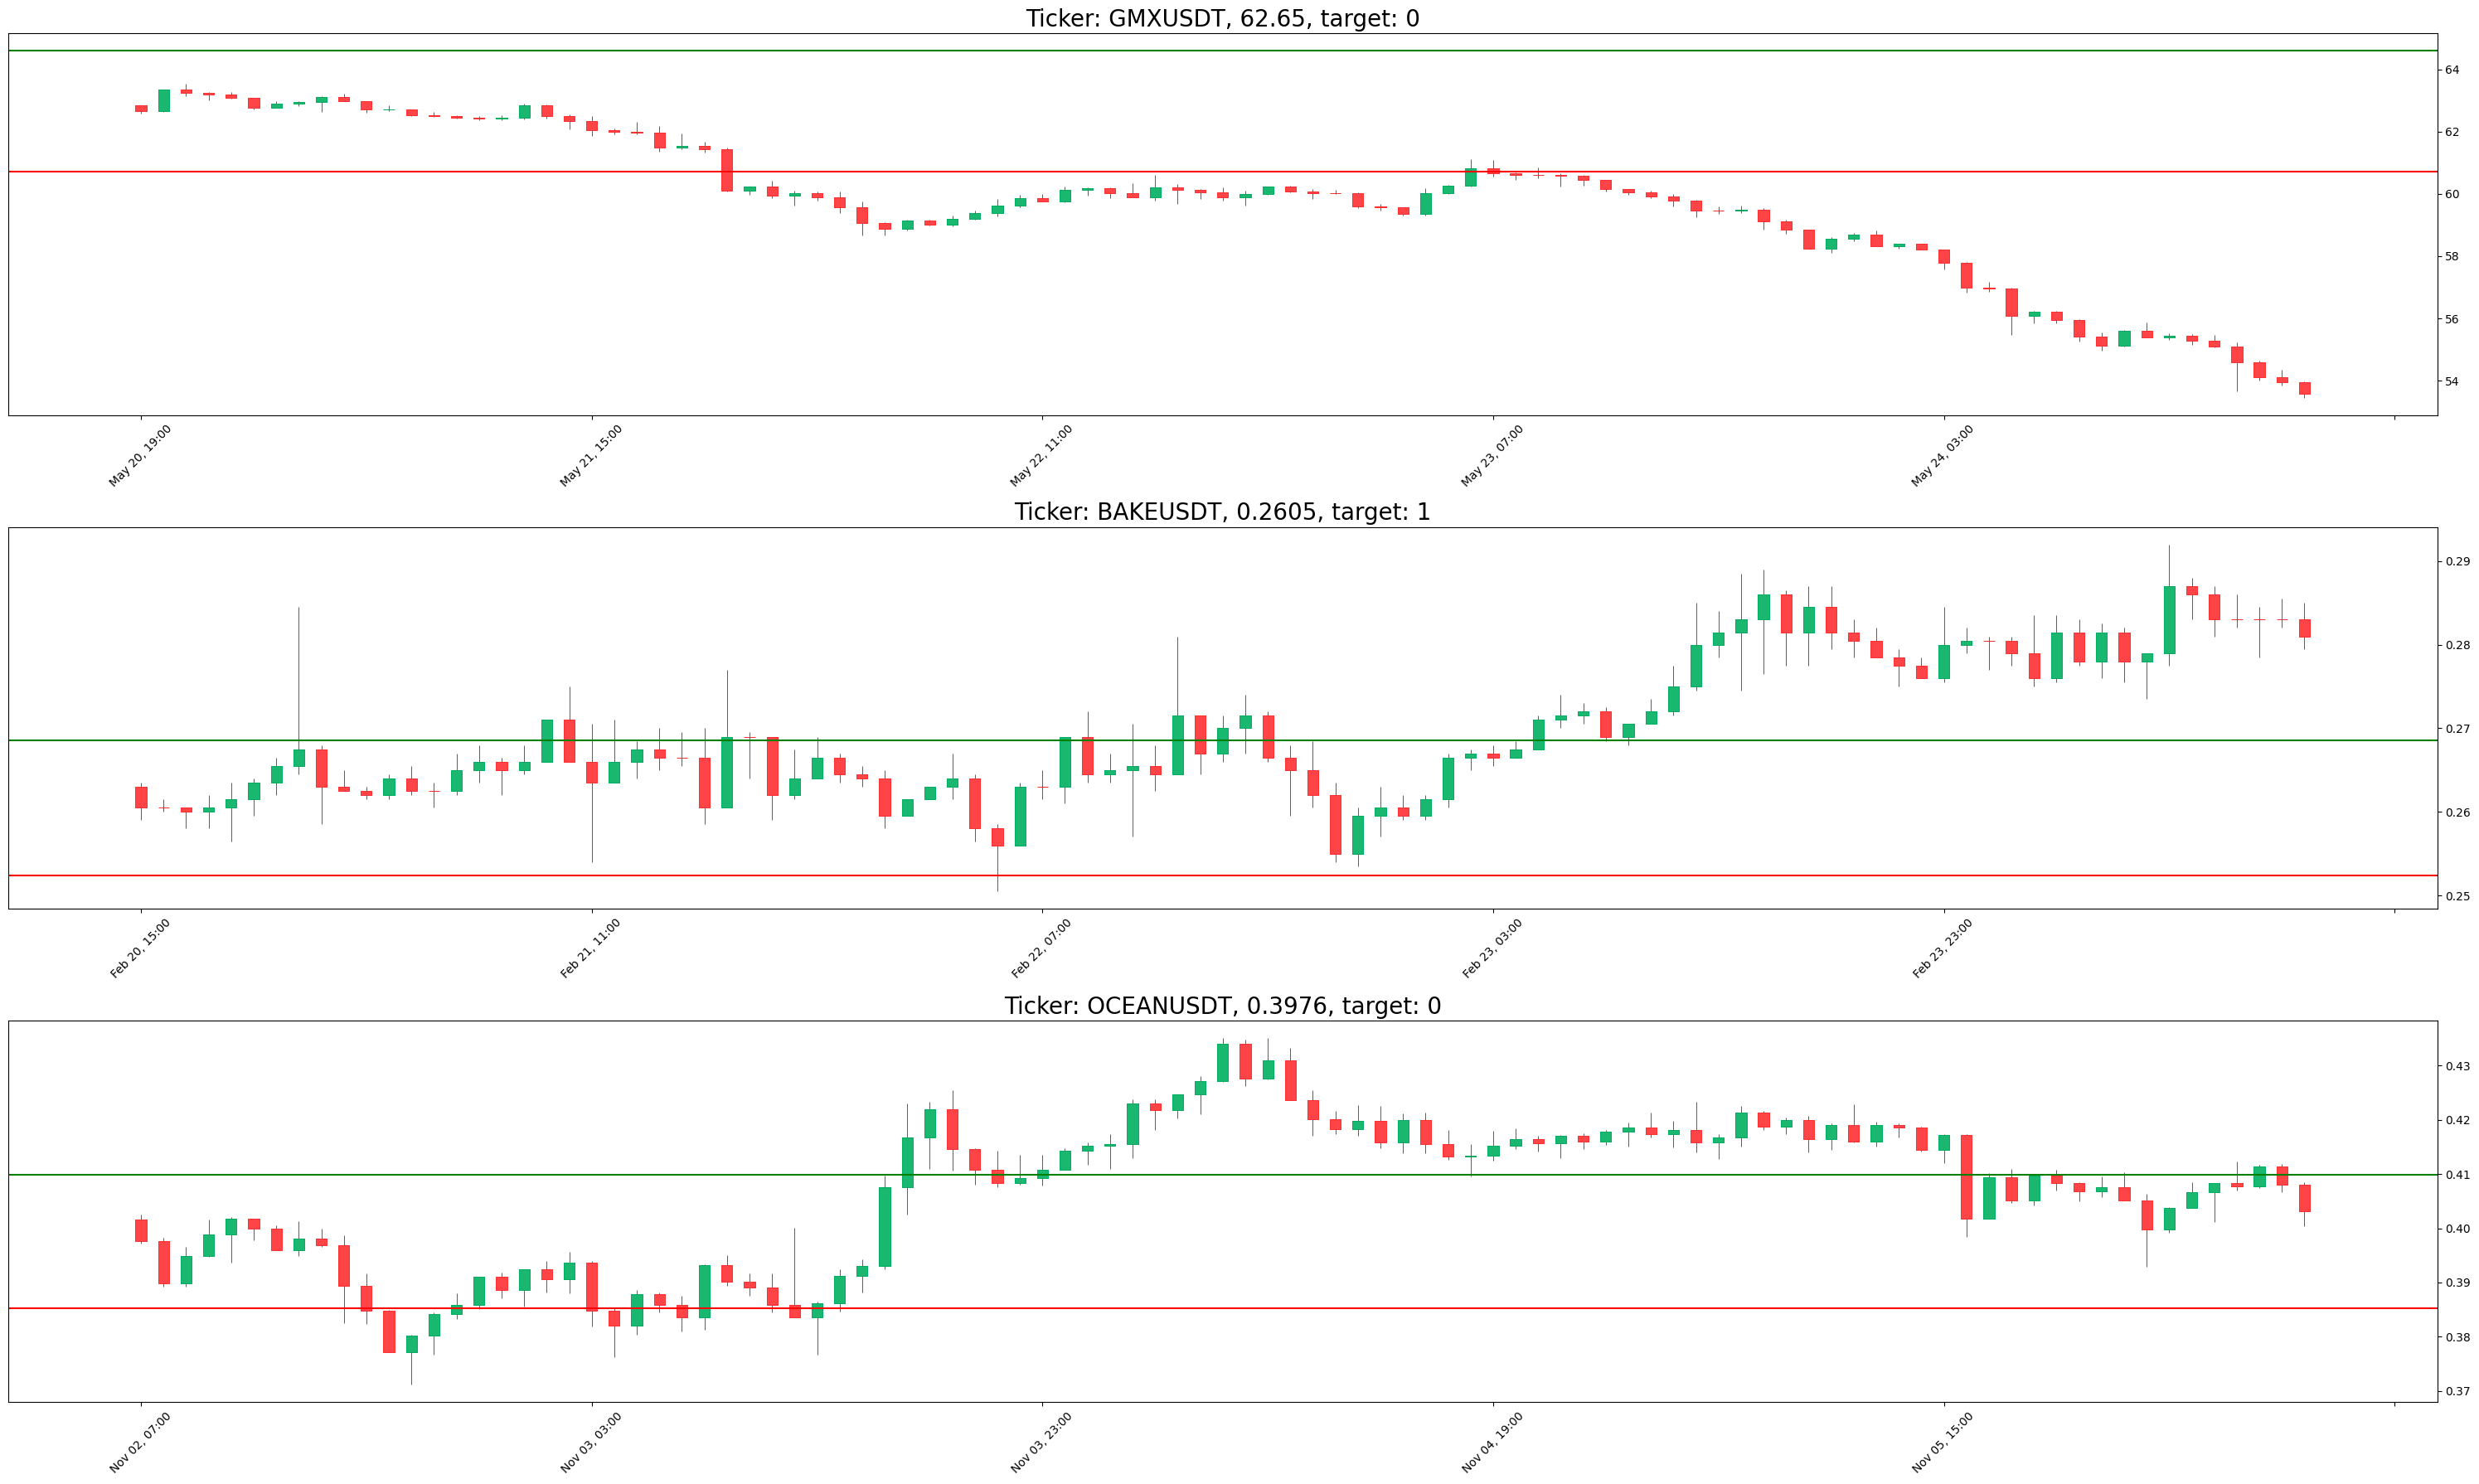

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Check sell trades correctness

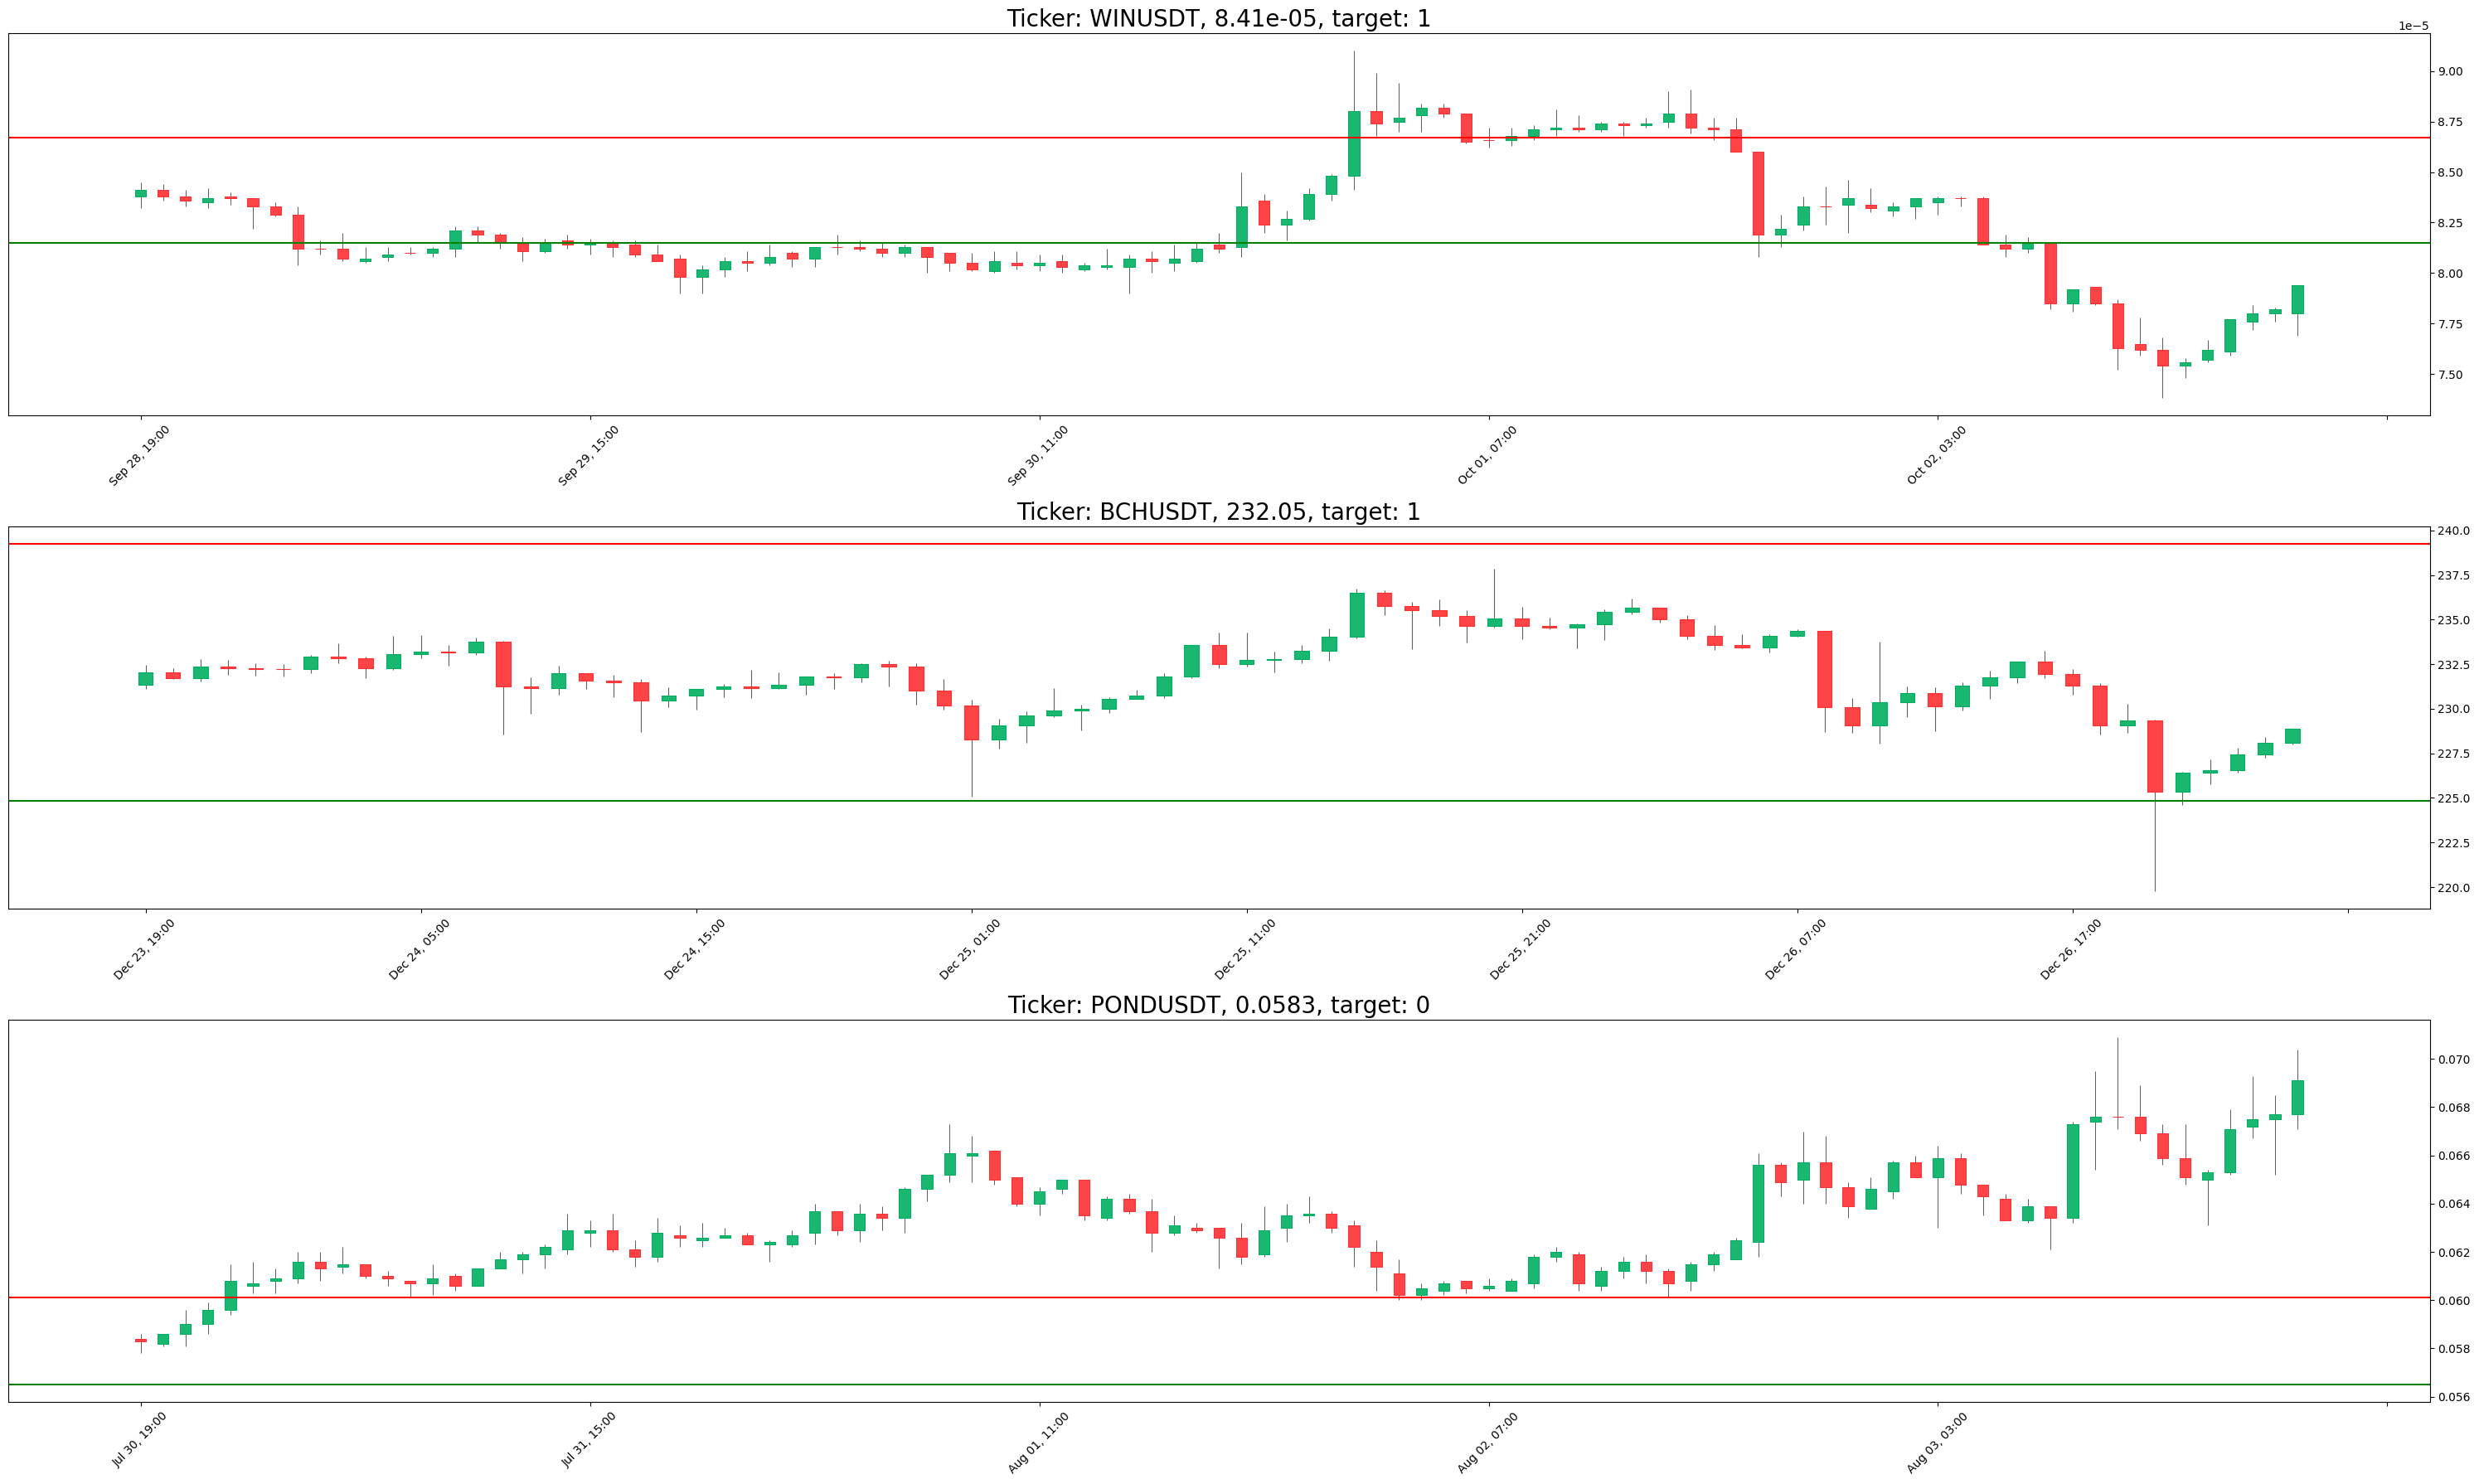

In [ ]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        price = row['close']
        target = row['target']
        ttype = row['ttype']

        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)
        
        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, {price}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

# Concat buy and sell datasets

,time,open,high,low,close,volume,rsi,stoch_slowk,stoch_slowd,stoch_slowk_dir,stoch_slowd_dir,stoch_diff,atr,close_smooth,linear_reg,linear_reg_angle,macd,macdhist,macd_dir,macdsignal,macdsignal_dir,open_prev_4,high_prev_4,low_prev_4,close_prev_4,volume_prev_4,rsi_prev_4,stoch_slowk_prev_4,stoch_slowd_prev_4,stoch_slowk_dir_prev_4,stoch_slowd_dir_prev_4,stoch_diff_prev_4,atr_prev_4,close_smooth_prev_4,linear_reg_prev_4,linear_reg_angle_prev_4,macd_prev_4,macdhist_prev_4,macd_dir_prev_4,macdsignal_prev_4,macdsignal_dir_prev_4,ticker,pattern,open_prev_8,high_prev_8,low_prev_8,close_prev_8,volume_prev_8,rsi_prev_8,stoch_slowk_prev_8,stoch_slowd_prev_8,stoch_slowk_dir_prev_8,stoch_slowd_dir_prev_8,stoch_diff_prev_8,atr_prev_8,close_smooth_prev_8,linear_reg_prev_8,linear_reg_angle_prev_8,macd_prev_8,macdhist_prev_8,macd_dir_prev_8,macdsignal_prev_8,macdsignal_dir_prev_8,open_prev_12,high_prev_12,low_prev_12,close_prev_12,volume_prev_12,rsi_prev_12,stoch_slowk_prev_12,stoch_slowd_prev_12,stoch_slowk_dir_prev_12,stoch_slowd_dir_prev_12,stoch_diff_prev_12,atr_prev_12,close_smooth_prev_12,linear_reg_prev_12,linear_reg_angle_prev_12,macd_prev_12,macdhist_prev_12,macd_dir_prev_12,macdsignal_prev_12,macdsignal_dir_prev_12,open_prev_16,high_prev_16,low_prev_16,close_prev_16,volume_prev_16,rsi_prev_16,stoch_slowk_prev_16,stoch_slowd_prev_16,stoch_slowk_dir_prev_16,stoch_slowd_dir_prev_16,stoch_diff_prev_16,atr_prev_16,close_smooth_prev_16,linear_reg_prev_16,linear_reg_angle_prev_16,macd_prev_16,macdhist_prev_16,macd_dir_prev_16,macdsignal_prev_16,macdsignal_dir_prev_16,open_prev_20,high_prev_20,low_prev_20,close_prev_20,volume_prev_20,rsi_prev_20,stoch_slowk_prev_20,stoch_slowd_prev_20,stoch_slowk_dir_prev_20,stoch_slowd_dir_prev_20,stoch_diff_prev_20,atr_prev_20,close_smooth_prev_20,linear_reg_prev_20,linear_reg_angle_prev_20,macd_prev_20,macdhist_prev_20,macd_dir_prev_20,macdsignal_prev_20,macdsignal_dir_prev_20,open_prev_24,high_prev_24,low_prev_24,close_prev_24,volume_prev_24,rsi_prev_24,stoch_slowk_prev_24,stoch_slowd_prev_24,stoch_slowk_dir_prev_24,stoch_slowd_dir_prev_24,stoch_diff_prev_24,atr_prev_24,close_smooth_prev_24,linear_reg_prev_24,linear_reg_angle_prev_24,macd_prev_24,macdhist_prev_24,macd_dir_prev_24,macdsignal_prev_24,macdsignal_dir_prev_24,open_prev_28,high_prev_28,low_prev_28,close_prev_28,volume_prev_28,rsi_prev_28,stoch_slowk_prev_28,stoch_slowd_prev_28,stoch_slowk_dir_prev_28,stoch_slowd_dir_prev_28,stoch_diff_prev_28,atr_prev_28,close_smooth_prev_28,linear_reg_prev_28,linear_reg_angle_prev_28,macd_prev_28,macdhist_prev_28,macd_dir_prev_28,macdsignal_prev_28,macdsignal_dir_prev_28,open_prev_32,high_prev_32,low_prev_32,close_prev_32,volume_prev_32,rsi_prev_32,stoch_slowk_prev_32,stoch_slowd_prev_32,stoch_slowk_dir_prev_32,stoch_slowd_dir_prev_32,stoch_diff_prev_32,atr_prev_32,close_smooth_prev_32,linear_reg_prev_32,linear_reg_angle_prev_32,macd_prev_32,macdhist_prev_32,macd_dir_prev_32,macdsignal_prev_32,macdsignal_dir_prev_32,open_prev_36,high_prev_36,low_prev_36,close_prev_36,volume_prev_36,rsi_prev_36,stoch_slowk_prev_36,stoch_slowd_prev_36,stoch_slowk_dir_prev_36,stoch_slowd_dir_prev_36,stoch_diff_prev_36,atr_prev_36,close_smooth_prev_36,linear_reg_prev_36,linear_reg_angle_prev_36,macd_prev_36,macdhist_prev_36,macd_dir_prev_36,macdsignal_prev_36,macdsignal_dir_prev_36,open_prev_40,high_prev_40,low_prev_40,close_prev_40,volume_prev_40,rsi_prev_40,stoch_slowk_prev_40,stoch_slowd_prev_40,stoch_slowk_dir_prev_40,stoch_slowd_dir_prev_40,stoch_diff_prev_40,atr_prev_40,close_smooth_prev_40,linear_reg_prev_40,linear_reg_angle_prev_40,macd_prev_40,macdhist_prev_40,macd_dir_prev_40,macdsignal_prev_40,macdsignal_dir_prev_40,open_prev_44,high_prev_44,low_prev_44,close_prev_44,volume_prev_44,rsi_prev_44,stoch_slowk_prev_44,stoch_slowd_prev_44,stoch_slowk_dir_prev_44,stoch_slowd_dir_prev_44,stoch_diff_prev_44,atr_prev_44,close_smooth_prev_44,linear_reg_prev_44,linear_reg_angle_prev_44,macd_prev_44,macdhist_prev_44,macd_dir_prev_

<AxesSubplot:>

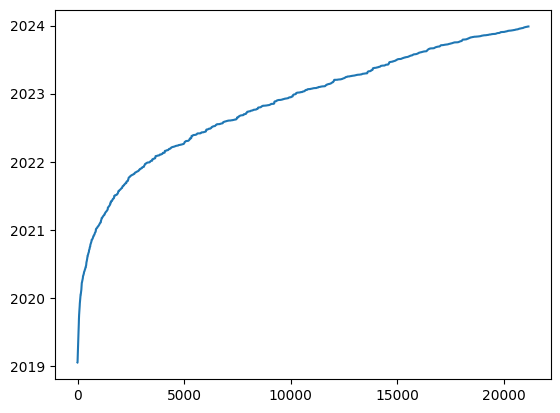

In [ ]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 192

if CFG.ttype == 'both':
    df_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
    df_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')
    df = pd.concat([df_buy, df_sell])
elif CFG.ttype == 'buy':
    df = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
else:
    df = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')


df = df[df['pattern'].isin(CFG.patterns_to_filter)]

display(df)

df = df.sort_values('time').reset_index(drop=True)
train_df = df

df['time'].plot()


In [ ]:
# 2023-12-26 19:00 - RNDRUSDT, EPXUSDT, XRPUSDT, APEUSDT, EOSUSDT, CFXUSDT
# 2023-12-26 23:00 - DYDXUSDT, KP3RUSDT
# TODO: remove the last signals from df
df[['time', 'ticker', 'ttype', 'target']].tail(30)

,time,ticker,ttype,target
21135,2023-12-26 15:00:00,NEOUSDT,sell,1
21136,2023-12-26 15:00:00,OGNUSDT,sell,1
21137,2023-12-26 15:00:00,XLMUSDT,sell,1
21138,2023-12-26 15:00:00,OMGUSDT,sell,1
21139,2023-12-26 15:00:00,BLUEBIRDUSDT,buy,0
21140,2023-12-26 15:00:00,BNBUSDT,buy,1
21141,2023-12-26 15:00:00,FETUSDT,buy,0
21142,2023-12-26 15:00:00,CAKEUSDT,buy,1
21143,2023-12-26 15:00:00,PONDUSDT,sell,1
21144,2023-12-26 15:00:00,MDXUSDT,sell,0


# Select features with BORUTA feature importance

In [ ]:
import pandas as pd
import lightgbm as lgb
from shaphypetune import BoostBoruta

if CFG.select_features:

  df.to_csv('df.csv', index=False)
  df_boruta = pd.read_csv('df.csv')
  os.remove('df.csv')
  
  params = {
            'n_estimators': 1000,
            'learning_rate': 0.02,
          #   'early_stopping_round': 100,
            'max_depth': 10,
            'subsample' : 0.7,
            'colsample_bytree': 0.85,
            'num_leaves': 24,
            'verbosity': -1,
            'importance_type': 'gain',
            'max_bin': 255,
            'reg_alpha': 1e-6,
            'reg_lambda': 1e-8
          }

  boruta_df_ = pd.DataFrame()
  features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]

  X, y, time = df_boruta[features], df_boruta['target'], df_boruta['time']

  tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
  eval_metric = 'logloss'

  # Stratify based on Class and Alpha (3 types of conditions)
  for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

      print(f'Fold: {fold}')
      # Split the dataset according to the fold indexes.
      X_train = X.iloc[train_idx]
      X_val = X.iloc[val_idx]
      y_train = y.iloc[train_idx]
      y_val = y.iloc[val_idx]

      clf = lgb.LGBMClassifier(**params)
      model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False)
      model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              eval_metric='logloss', 
              callbacks=[lgb.log_evaluation(100)])

      boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
      if boruta_df_.shape[0] == 0:
          boruta_df_ = boruta_importance_df.copy()
      else:
          boruta_df_ += boruta_importance_df

  boruta_df_ = boruta_df_.sort_values('importance')
  boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

  del df_boruta

# Select features with permutation importance and GBM feature importance

In [ ]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    features = [c for c in df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


params = {
          'n_estimators': 1000,
          'learning_rate': 0.02,
        #   'early_stopping_round': 100,
          'max_depth': 9,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-8
        }

task_type = 'cls'

if task_type == 'cls':
    params['boosting_type'] = 'dart'
    params['objective'] = 'binary'
else:
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'

if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(df, permut=True)

# Combine importances and save them

In [ ]:
if CFG.select_features:
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    boruta_df_['rank'] = boruta_df_['importance'].rank()
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'feature_importance_{CFG.ttype}.csv')
else:
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')

# Train_test split based on ticker groups

In [ ]:
idxs = list()

def model_train(df, train_df, features, task_type, how, n_folds, low_bound, high_bound, train_test): 
    X, time = train_df[features], train_df['time']
    # X = pd.concat([X, pd.get_dummies(train_df[['ttype']], drop_first=True)], axis=1)
    y = train_df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(train_df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(train_df) * 2) // (n_folds * 3))

        print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            val_idx = time[time > max_time].index.tolist()
            
            idxs.append((fit_idx, val_idx))
            
            if fold == 0:
                first_val_idx = val_idx[0]
            
            print(f'Fold #{fold + 1}')
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            display(y_val.value_counts())
            display(train_df.loc[val_idx[0], 'time'])
            display(train_df.loc[val_idx[-1], 'time'])
            
            model = lgb.LGBMClassifier(**params)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                        eval_metric='logloss')#, callbacks = [lgb.log_evaluation(100)])

            val_preds = model.predict_proba(X_val)
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:,1], low_bound, high_bound)
            print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                  f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n')
            oof[val_idx, 0] = val_preds[:,1]

        return oof, model, first_val_idx
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        model = lgb.LGBMClassifier(**params)
        model.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        return np.zeros([df.shape[0], 1]), model, None

def prepare_features(fi, feature_num, features_to_exclude):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    fi = fi['Feature'].head(feature_num)
    feature_dict = defaultdict(list)
    features = list()

    # exclude some features by their numbers
    feature_idx = [i for i in range(feature_num) if i not in features_to_exclude]
    fi = (np.array(fi)[feature_idx])
    
    for f in fi:
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf[oof < low_bound] = 0
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]

    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

train_test = 'fold' # fold, test, full, inference
feature_num = 163

low_bound, high_bound = 0.32, 0.68
params = {
    'boosting_type': 'dart',
    'n_estimators': 1500,
    'learning_rate': 0.02,
    # 'early_stopping_round': 50,
    'max_depth': 10,
    'colsample_bytree': 0.85,
    'subsample': 0.85,
    'subsample_freq': 1,
    'num_leaves': 23,
    'verbosity': -1,
    'max_bin': 255,
    'reg_alpha': 1e-6,
    'reg_lambda': 1e-7,
    'objective': 'binary',
    # 'is_unbalance': True,
    # 'class_weight': 'balanced',
    'metric': 'average_precision'
    }

if CFG.train_LGBM:
    # for j in tqdm(range(1, 162)):
    #     print(j)
    features_to_exclude = []
    fi = pd.read_csv(f'feature_importance_{CFG.ttype}.csv')
    features, feature_dict = prepare_features(fi, feature_num, features_to_exclude)
    
    if train_test != 'inference':
        oof, model, first_val_idx = model_train(df, train_df, features, task_type=task_type, how='lgbm', n_folds=5, low_bound=low_bound, high_bound=high_bound, train_test=train_test)
    if train_test == 'fold':
        # fold
        y = train_df['target'][first_val_idx:]
        oof = oof[first_val_idx:]
        oof_val_score = log_loss(y, oof)
        oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
        print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
              f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}')
        # feature_exclude_dict[j] = (oof_val_score, oof_conf_prec_score, oof_conf_obj_pct)
    elif train_test == 'full':
        joblib.dump(model, f'lgbm.pkl')
        # save feature dictionary for further inference
        with open(f'features.json', 'w') as f:
            json.dump(feature_dict, f)
    

Training with 163 features
Fold #1


1    8320
0    6037
Name: target, dtype: int64

Timestamp('2022-08-12 11:00:00')

Timestamp('2023-12-26 19:00:00')

Logloss: 0.6508528856008869, Confident objects precision: 0.7231132075471698
Number of confident objects 4240, % of confident objects: 0.2953263216549418

Fold #2


1    6693
0    4940
Name: target, dtype: int64

Timestamp('2022-12-11 11:00:00')

Timestamp('2023-12-26 19:00:00')

Logloss: 0.645927355475097, Confident objects precision: 0.7434908389585342
Number of confident objects 3111, % of confident objects: 0.2674288661566234

Fold #3


1    4943
0    3593
Name: target, dtype: int64

Timestamp('2023-04-06 23:00:00')

Timestamp('2023-12-26 19:00:00')

Logloss: 0.6465405140028758, Confident objects precision: 0.7554727526781556
Number of confident objects 2147, % of confident objects: 0.251522961574508

Fold #4


1    3372
0    2389
Name: target, dtype: int64

Timestamp('2023-07-21 15:00:00')

Timestamp('2023-12-26 19:00:00')

Logloss: 0.643974743921349, Confident objects precision: 0.7856573705179283
Number of confident objects 1255, % of confident objects: 0.21784412428397848

Fold #5


1    1685
0    1146
Name: target, dtype: int64

Timestamp('2023-10-27 07:00:00')

Timestamp('2023-12-26 19:00:00')

Logloss: 0.6270851463742853, Confident objects precision: 0.8030534351145038
Number of confident objects 655, % of confident objects: 0.2313670081243377

Total fold Logloss: 0.6431934135441122, Total confident objects precision: 0.760422615648201
Number of confident objects: 3502, Total % of confident objects: 0.24392282510273733


In [ ]:
# vol 1e6
# Training with 163 features
# Fold #1
# 1    1588
# 0    1026
# Name: target, dtype: int64Timestamp('2022-07-23 19:00:00')Timestamp('2022-11-28 07:00:00')
# Logloss: 0.6509511847960535, Confident objects precision: 0.7392900856793145
# Number of confident objects 817, % of confident objects: 0.31254781943381793

# Fold #2
# 1    1440
# 0    1174
# Name: target, dtype: int64Timestamp('2022-11-28 07:00:00')Timestamp('2023-03-18 03:00:00')
# Logloss: 0.6455771486782789, Confident objects precision: 0.7356770833333334
# Number of confident objects 768, % of confident objects: 0.2938026013771997

# Fold #3
# 1    1531
# 0    1083
# Name: target, dtype: int64Timestamp('2023-03-18 03:00:00')Timestamp('2023-07-05 19:00:00')
# Logloss: 0.6385915122070807, Confident objects precision: 0.7517630465444288
# Number of confident objects 709, % of confident objects: 0.2712318286151492

# Fold #4
# 1    1484
# 0    1130
# Name: target, dtype: int64Timestamp('2023-07-05 19:00:00')Timestamp('2023-10-17 11:00:00')
# Logloss: 0.6610915945708405, Confident objects precision: 0.7290909090909091
# Number of confident objects 550, % of confident objects: 0.21040550879877581

# Fold #5
# 1    1577
# 0    1037
# Name: target, dtype: int64Timestamp('2023-10-17 11:00:00')Timestamp('2023-12-23 11:00:00')
# Logloss: 0.6286457569145518, Confident objects precision: 0.8086124401913876
# Number of confident objects 627, % of confident objects: 0.23986228003060445

# Total fold Logloss: 0.644971439433361, Total confident objects precision: 0.7519446845289542
# Number of confident objects: 3471, Total % of confident objects: 0.2655700076511094

# Display PR curve

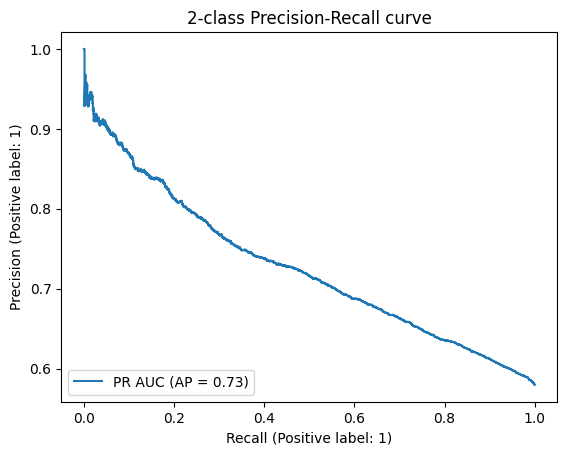

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

if train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y, oof, name="PR AUC"
    )
    _ = disp.ax_.set_title("2-class Precision-Recall curve")

# vol 1e6 AP=0.72

# Find the best threshold

ic| bound: 0.5, prec_score: 0.62388, obj_num: 11398, obj_pct: 0.79
ic| bound: 0.51, prec_score: 0.62928, obj_num: 11038, obj_pct: 0.77
ic| bound: 0.52, prec_score: 0.63372, obj_num: 10683, obj_pct: 0.74
ic| bound: 0.53, prec_score: 0.63744, obj_num: 10288, obj_pct: 0.72
ic| bound: 0.54, prec_score: 0.64367, obj_num: 9898, obj_pct: 0.69
ic| bound: 0.55, prec_score: 0.65091, obj_num: 9496, obj_pct: 0.66
ic| bound: 0.56, prec_score: 0.65833, obj_num: 9079, obj_pct: 0.63
ic| bound: 0.57, prec_score: 0.66593, obj_num: 8612, obj_pct: 0.6
ic| bound: 0.58, prec_score: 0.67413, obj_num: 8126, obj_pct: 0.57
ic| bound: 0.59, prec_score: 0.68181, obj_num: 7640, obj_pct: 0.53
ic| bound: 0.6, prec_score: 0.68952, obj_num: 7131, obj_pct: 0.5
ic| bound: 0.61, prec_score: 0.69902, obj_num: 6655, obj_pct: 0.46
ic| bound: 0.62, prec_score: 0.7078, obj_num: 6191, obj_pct: 0.43
ic| bound: 0.63, prec_score: 0.71897, obj_num: 5704, obj_pct: 0.4
ic| bound: 0.64, prec_score: 0.72724, obj_num: 5239, obj_pct: 0.

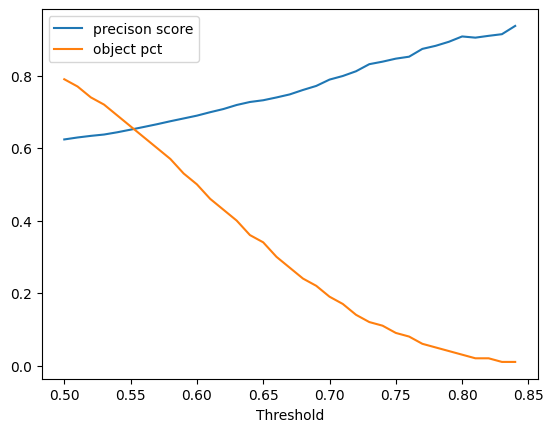

In [ ]:
from icecream import ic

if train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    for hb in np.arange(0.5, 0.85, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y, oof, 1-hb, hb)
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        ic(bound, prec_score, obj_num, obj_pct)

    line1 = plt.plot(np.arange(0.5, 0.85, 0.01), prec_score_list, label='precison score')
    line2 = plt.plot(np.arange(0.5, 0.85, 0.01), obj_pct_list, label='object pct')
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

In [ ]:
# vol 1e6
# ic| bound: 0.5, prec_score: 0.62551, obj_num: 10481, obj_pct: 0.8
# ic| bound: 0.51, prec_score: 0.63125, obj_num: 10164, obj_pct: 0.78
# ic| bound: 0.52, prec_score: 0.63461, obj_num: 9899, obj_pct: 0.76
# ic| bound: 0.53, prec_score: 0.63983, obj_num: 9576, obj_pct: 0.73
# ic| bound: 0.54, prec_score: 0.6449, obj_num: 9234, obj_pct: 0.71
# ic| bound: 0.55, prec_score: 0.64998, obj_num: 8848, obj_pct: 0.68
# ic| bound: 0.56, prec_score: 0.65674, obj_num: 8463, obj_pct: 0.65
# ic| bound: 0.57, prec_score: 0.66484, obj_num: 8041, obj_pct: 0.62
# ic| bound: 0.58, prec_score: 0.67203, obj_num: 7577, obj_pct: 0.58
# ic| bound: 0.59, prec_score: 0.67843, obj_num: 7168, obj_pct: 0.55
# ic| bound: 0.6, prec_score: 0.68426, obj_num: 6800, obj_pct: 0.52
# ic| bound: 0.61, prec_score: 0.69121, obj_num: 6396, obj_pct: 0.49
# ic| bound: 0.62, prec_score: 0.70216, obj_num: 5926, obj_pct: 0.45
# ic| bound: 0.63, prec_score: 0.70704, obj_num: 5482, obj_pct: 0.42
# ic| bound: 0.64, prec_score: 0.71542, obj_num: 5053, obj_pct: 0.39
# ic| bound: 0.65, prec_score: 0.72519, obj_num: 4636, obj_pct: 0.35
# ic| bound: 0.66, prec_score: 0.73463, obj_num: 4213, obj_pct: 0.32
# ic| bound: 0.67, prec_score: 0.74347, obj_num: 3828, obj_pct: 0.29
# ic| bound: 0.68, prec_score: 0.75194, obj_num: 3471, obj_pct: 0.27
# ic| bound: 0.69, prec_score: 0.76187, obj_num: 3074, obj_pct: 0.24
# ic| bound: 0.7, prec_score: 0.77096, obj_num: 2720, obj_pct: 0.21
# ic| bound: 0.71, prec_score: 0.78214, obj_num: 2396, obj_pct: 0.18
# ic| bound: 0.72, prec_score: 0.79732, obj_num: 2092, obj_pct: 0.16
# ic| bound: 0.73, prec_score: 0.80855, obj_num: 1802, obj_pct: 0.14
# ic| bound: 0.74, prec_score: 0.82368, obj_num: 1520, obj_pct: 0.12
# ic| bound: 0.75, prec_score: 0.83815, obj_num: 1279, obj_pct: 0.1
# ic| bound: 0.76, prec_score: 0.8422, obj_num: 1071, obj_pct: 0.08
# ic| bound: 0.77, prec_score: 0.85244, obj_num: 881, obj_pct: 0.07
# ic| bound: 0.78, prec_score: 0.86192, obj_num: 717, obj_pct: 0.05
# ic| bound: 0.79, prec_score: 0.87895, obj_num: 570, obj_pct: 0.04
# ic| bound: 0.8, prec_score: 0.88532, obj_num: 436, obj_pct: 0.03
# ic| bound: 0.81, prec_score: 0.89275, obj_num: 345, obj_pct: 0.03
# ic| bound: 0.82, prec_score: 0.89961, obj_num: 259, obj_pct: 0.02
# ic| bound: 0.83, prec_score: 0.91919, obj_num: 198, obj_pct: 0.02
# ic| bound: 0.84, prec_score: 0.92949, obj_num: 156, obj_pct: 0.01